# Modsim Project - Snapshot 1
### September 27, 2018
### Solomon and Jon

### Driving question: Which US city would be worst for an epidemic to start from?
Inspired by the TV and blockbuster thrillers _Contagion_, _I Am Human Legend_, and _The Walking Dead_, we debated which city would be the most suscetible to starting a nationwide epidemic.

### Methodology
After being unable to come to any solid conclusions, we figured we might as well model the outbreak using real US geography and major transportation throughways.

We aggregated several different datasets including:
- [State population](https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population)
- [Continential US flight data](https://l.facebook.com/l.php?u=https%3A%2F%2Fwww.transtats.bts.gov%2FDL_SelectFields.asp%3FTable_ID%3D236&h=AT0kELPXy48zq_TIGgsJGGkhpZKHFU6rf_eEqNI-aeB4I0actw5aQoUbiinAZzLiNXRAanLTmFgDi1fuAJrdJwd-WZr1LZ6MDhQLpFPVs6FNhfqTxXmZxpuEp8-TAY0GEqWVIMHmaSc)
- [DoT traffic counts & volume](https://connect.ncdot.gov/resources/State-Mapping/Pages/Traffic-Survey-GIS-Data.aspx)
- [GIS Location data for each state and airport](https://inkplant.com/code/state-latitudes-longitudes)
- [Institue for Health Metrics and Evaluation state healthiness metric](http://www.healthdata.org/data-visualization/us-health-map)

Our model creates a network of states (nodes) connected by throughways of inbound and outbound traffic (branches). We used a directional graph with the attributes of each node based on population data, neighboring states, and DoT interstate traffic counts.

Additional branches were also dynamically added and removed connecting states with flights leaving infected states. We pooled flight data from 2017 and can generate a historical model and predicted model based on flight frequency at various points of the year.

### Let's do some basic importing:

To help with cleanliness and to simplify the display process, we developed our own module 'spatial_infection_model' to contain the complicated display code and network manager.

It will also wrap some of the basic simulation functionality -- like our own custom ModSimPy.

In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from spatial_infection_model import simulation_controller, visualize
from bokeh.io import show, output_notebook
import pandas as pd
from numpy.random import normal
%matplotlib inline

### Build our simulation:

In [2]:
USA_SIM = simulation_controller.intialize()

#### Load in the states:

In [3]:
USA_SIM.nodes_from_data("data/state_data.csv",
                        index = "abv",
                        population = "population",
                        num_susceptible = "population",
                        num_dead = 0,
                        num_exposed = 0,
                        num_infected = 0,
                        num_recovered = 0,                
                        infection_resistance = 0,
                        posx = "longitude",
                        posy = "latitude",
                        )

Added nodes from: data/state_data.csv


#### Create paths between each state with inbound and outbound traffic volume:

In [4]:
USA_SIM.branches_from_data("data/neighbors-states.csv",
                            nodeA = "state1",
                            nodeB = "state2",
                            weight = 0
                            )

Added 109 branches from: data/neighbors-states.csv


### Let's add a metric of healthiness to each state:
Our SIR model will need a metric of infection resistance which we will base off of the healthiness metric determined by the Institute for Health Metrics and Evaluation. We normalized their 2017 data to values between 10% and 90% resistant to disease.

We then inserted this data into each node.

The healthiness spread varies across the US:

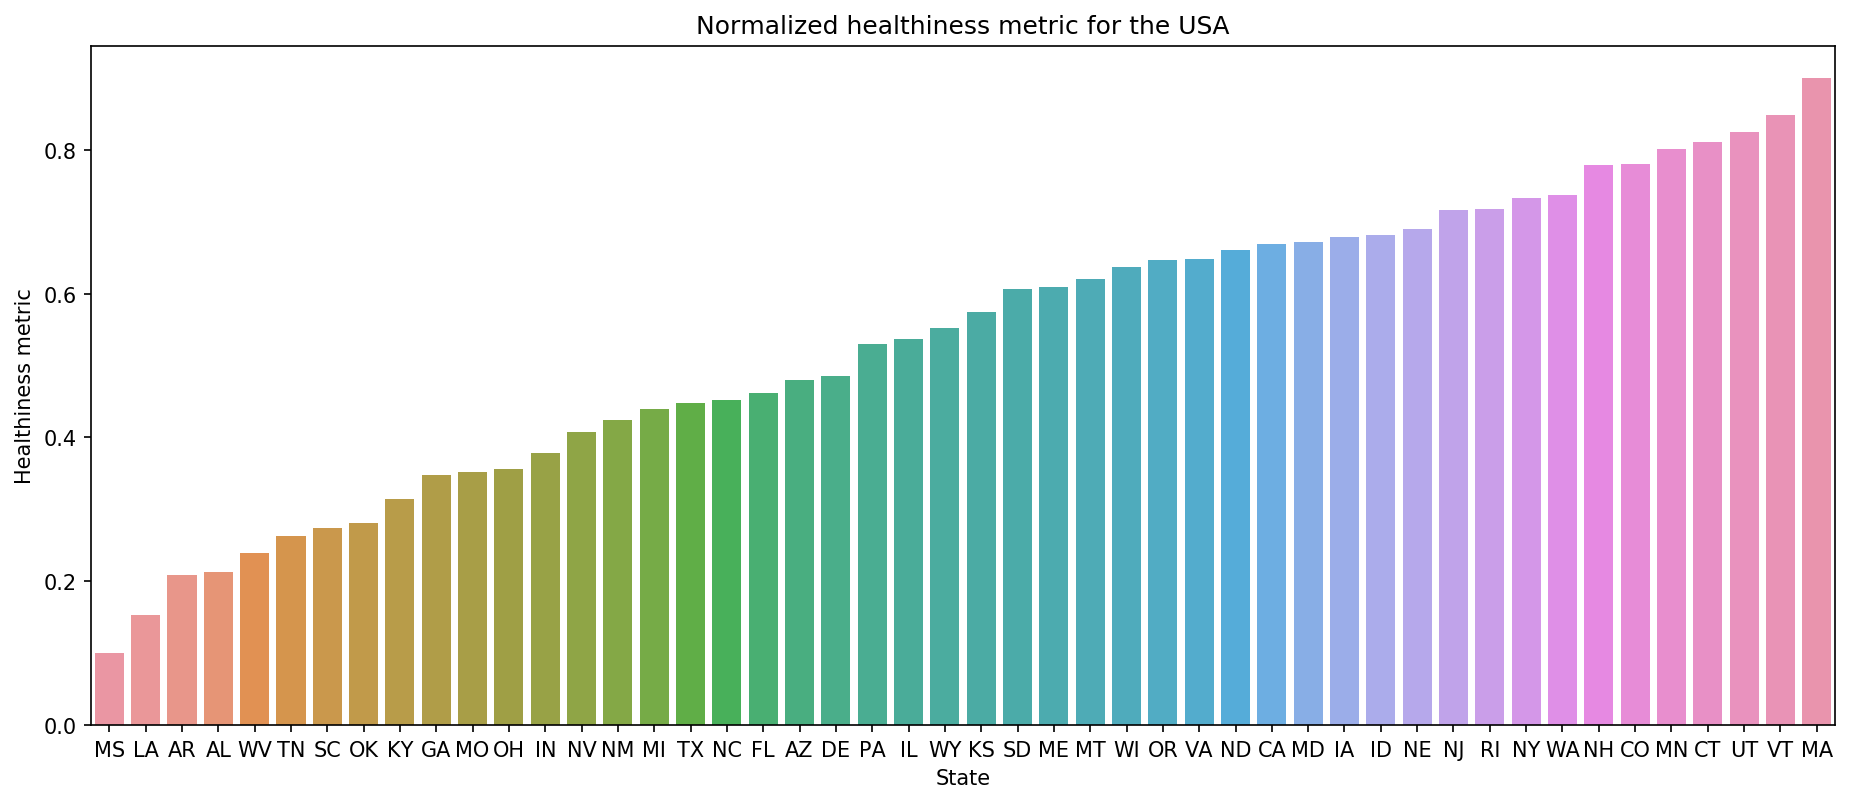

In [5]:
visualize.healthiness_metric()

In [6]:
USA_SIM.node_attributes_from_data("././data/state-healthiness.csv", attribute_name = "resistance")

Added metric for 48 states.


#### Visualize the map and network model:

In [7]:
maps, showfunc = visualize.generate_map(USA_SIM)
output_notebook()
#showfunc(maps)

Loading BokehJS ...

### Great! We've built a network model for the United States of America
We've loaded in lots of data and built a complex network. We'd like to run a simulation against the network model multiple times, but don't want to deal with the performance decrease of loading in data.

We can save the object to a file and load it in every time we need a fresh copy:

In [8]:
import pickle

with open(r"USA_SIM.pickle", "wb") as output_file:
    pickle.dump(USA_SIM, output_file)

## Build an infection model:

Now that our network model is saved, let's develop a flexible infection model.

We'll be using the SEIR model (susceptible, exposed, infected, resistant), expressed as continuous differential equations and approximated using Euler's method

The original iteration of this model was a simple SIR model, but version two has added stochasticity and the exposure period, which we found to greatly enhance the accuracy of the model.


### Original infection model

In [37]:
from collections import namedtuple

# Original infection model, depreciated
Infection_Update_State = namedtuple('Infection_Update_State',
                                    ["healthy", "newly_infected", "newly_recovered", "newly_dead"])


def recovery_chance_to_death_chance(recovery_chance):
    return (1 - recovery_chance) / 50

def SIR_infection_update(*, healthy_pop: int, infected_pop: int, resistance: float,
                     recovery_chance: float) -> Infection_Update_State:
    # Greater infected -> more chance to transmit
    # Less healthy -> less chance to transmit
    # Logistic?

    # y' = resistance * y * (1-y)/pop

    total_pop = healthy_pop + infected_pop
    d_infected: int = max(
        round(1 / relativeNormal(resistance, div=3) * infected_pop * (1 - infected_pop / total_pop)),
        0
    )
    if healthy_pop - d_infected < 0: d_infected = 0

    d_recovered: int = max(round(relativeNormal(recovery_chance) * infected_pop), 0)  # Simple linear model
    d_dead: int = max(round(relativeNormal(recovery_chance_to_death_chance(recovery_chance)) * infected_pop), 0)

    healthy: int = healthy_pop - d_infected

    return Infection_Update_State(
        healthy=healthy,
        newly_infected=d_infected,
        newly_dead=d_dead,
        newly_recovered=d_recovered
    )

def test_v1_model():
    healthy = 100000
    infected = 500
    dead = 0
    recovered = 0
    resistance = 3.5
    recovery = 0.2

    X = []
    Y = []
    infected_escrow = [0] * 20  # Time delay (janky incubation period)
    start = time()
    for i in range(350):
        # resistance = 2.5 + 1 * i / 200
        if healthy <= 0: healthy = 0
        ret = SIR_infection_update(healthy_pop=healthy, infected_pop=infected, resistance=resistance,
                               recovery_chance=recovery)
        healthy = ret.healthy
        infected_escrow.append(ret.newly_infected)
        infected += infected_escrow.pop(0) - (ret.newly_dead + ret.newly_recovered)
        dead += ret.newly_dead
        recovered += ret.newly_recovered

        X.append(i)
        Y.append([healthy, infected, dead, recovered, healthy + recovered])
        # Y.append([healthy, infected])
    end = time()

    print(start - end)
    f = plt.figure()
    l1, l2, l3, l4, l5 = plt.plot(X, Y)
    plt.legend((l1, l2, l3, l4, l5), ('healthy', 'infected', 'dead', 'recovered (immune)', 'alive'))
    plt.xlabel('t')
    plt.ylabel('pop')
    plt.show()


def relativeNormal(c, div=2.5):
    return normal(c, abs(c) / div)
    

### Iterated SEIR-based infection model

In [38]:

def SEIR_model_update(state):
 #   β = 0.6 # infection rate
#    γ = 0.2 # recovery rate
    if not "resistance" in state:
        state['resistance'] = 0.5
    β = relativeNormal((1 - state["resistance"])**2)
    γ = relativeNormal(state["resistance"])
    α = relativeNormal(0.2) # α^-1 is average exposed-but-not-infected time 
    µ = relativeNormal(0.05) # death rate (from infection)
    ζ = relativeNormal(γ*2) # exposure to recovery 
    
    # TODO: β+γ from state infection resistance
    
    if state["num_susceptible"] + state["num_infected"] <=0: 
        return

    # DFNs
    # S -> suspectable (healthy)
    # E -> exposed (escrow)
    # I -> infected 
    # R -> recoverd (immune)
    N = state["num_susceptible"] + state["num_exposed"] + state["num_infected"] + state["num_recovered"]
    S,E,I,R,D = \
        state["num_susceptible"], state["num_exposed"], state["num_infected"], state["num_recovered"], state["num_dead"]        
        
    ΔS = -β * I/N * S
    ΔE = β * I/N * S + -α*E + -ζ*E
    ΔI = α*E + -γ*I + -µ*I 
    ΔR = γ*I + ζ*E
    ΔD = µ*I
    
    state["num_susceptible"] += ΔS
    state["num_exposed"] += ΔE
    state["num_infected"] += ΔI
    state["num_recovered"] += ΔR
    state["num_dead"] += ΔD

### We also need to model the movement of people 
From the DoT national traffic counts data, we determined that about 1% of each state leaves the state via highways and interstates each day. This rate is about equal to the amount of traffic entering the state, meaning that each state is, on average, at about equilibrium for interstate travelers.

Our model assumes that 1% of each state will daily emigrate to its neighbors divided proportionally by their populations. This way, each state has population counts in equilibrium with realistic traffic flow.

We also wanted to model movement of people across the nation. We compiled a year's worth of flight data from the US Bureau of Transportation and moved people from state to state based on the historical data.


In [10]:
def people_movement_model(sim):
    for node_id, node in sim.G.nodes.items():
        #5% leave the state each day, divided among neighbors proportionate to their population
        total_mobile = node['num_susceptible'] + node['num_exposed'] + node['num_recovered']

        emigration_rate = 0.05
        emigration_count = emigration_rate * total_mobile
        outboundpop = 0
        for neighbor in sim.G.neighbors(node_id):
            outboundpop += sim.G.nodes[neighbor]['population']
        
        for neighbor in sim.G.neighbors(node_id):
            coefficient = sim.G.nodes[neighbor]['population']/outboundpop
            transact_people(node, sim.G.nodes[neighbor], coefficient * emigration_count) # Actually move people
    
    # Checking for data presence and loading if necessary
    if not hasattr(sim, 'flight_data'): sim.flight_data = pd.read_csv("data/flights_2017.csv")
    if not hasattr(sim, 'flight_index'): sim.flight_index = 0
    if not hasattr(sim, 'current_date'): sim.current_date = 0
    if not hasattr(sim, 'last_date'): sim.last_date = 0

    while sim.current_date == sim.last_date:
        row = sim.flight_data.iloc[sim.flight_index%450017] # Loop flight data from month of january
        
        nodeA_id = row['ORIGIN_STATE_ABR']
        nodeB_id = row['DEST_STATE_ABR']
        transact_people(sim.G.nodes[nodeA_id], sim.G.nodes[nodeB_id], 150)
        sim.last_date = sim.current_date
        sim.current_date = row['FL_DATE']        
        sim.flight_index += 1


In [11]:
def transact_people(nodeA, nodeB, people):
     
    total_mobile = nodeA['num_susceptible'] + nodeA['num_exposed'] + nodeA['num_recovered']
    
    leaving_susceptible = (nodeA['num_susceptible'] / total_mobile) * people
    leaving_exposed = (nodeA['num_exposed'] / total_mobile) * people
    leaving_recovered = (nodeA['num_recovered'] / total_mobile) * people
    
    nodeA['num_susceptible'] -= leaving_susceptible
    nodeA['num_exposed'] -= leaving_exposed
    nodeA['num_recovered'] -= leaving_recovered       
    
    nodeB['num_susceptible'] += leaving_susceptible
    nodeB['num_exposed'] += leaving_exposed
    nodeB['num_recovered'] += leaving_recovered    


### Simulation!
We've prepared a network model, an infection model, and a flight model. We can use our models with the simulation_controller to generate and graph the appropriate data.

Let's build a function that simulates a prepped model:


In [15]:
import copy

with open(r"tmp/USA_SIM.pickle", "rb") as input_file:
    tmp_sim = pickle.load(input_file)

def simulate_infection(state, num_infected, steps=500):
    tmp  = copy.deepcopy(tmp_sim)

    results = tmp.simulate(node_update = SEIR_model_update,   # is executed for every node per step
                               model_update = people_movement_model,   # is executed once per step
                               overwrite_nodes = { state:{"num_infected": num_infected} },
                               steps = steps
                               ) # returns as reults object
    return results

### Let's test the simulation by seeding Texas with 100 sick people.

20014701.027517993


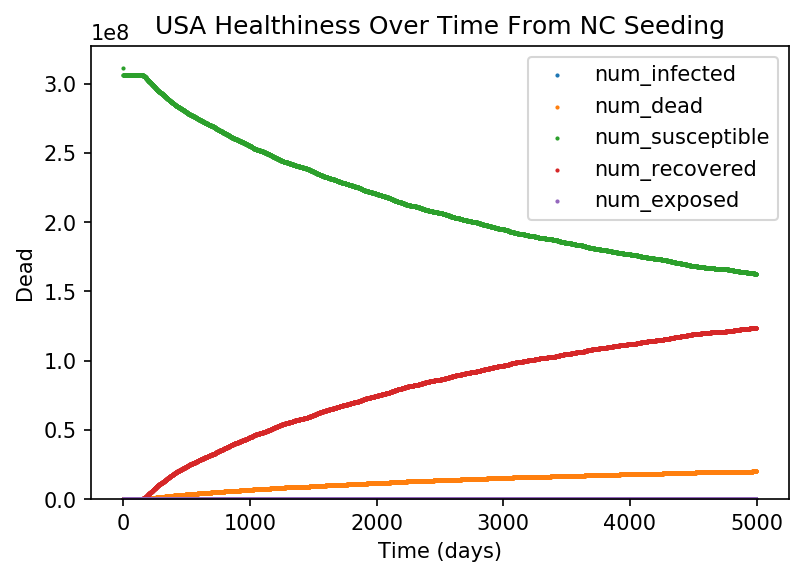

In [20]:
TX_sim = simulate_infection("TX", num_infected = 100, steps = 5000)
fig = TX_sim.plot_data("all", data_attributes = ['num_infected', 'num_dead', 'num_susceptible', 'num_recovered', 'num_exposed'])
plt.title("USA Healthiness Over Time From NC Seeding")
plt.xlabel("Time (days)")
plt.ylabel("Dead")
print(TX_sim.data['all']['num_dead'][-1])


### Now let's sweep through all fifty states and see the resulting number of deaths

In [28]:
states = {}

from multiprocessing import Pool

def thread(x): # Thread process for discrete parallelism
    num = 64
    avg = 0
    tick = 0
    for i in range(num):
        sim = simulate_infection(x, num_infected=100, steps=500)
        if sim.data['all']['num_dead'][-1] > 0:
            avg += sim.data['all']['num_dead'][-1]
            tick += 1
    print(x, int(avg/tick))
    return x, int(avg/tick)

p = Pool(8)
data = p.imap_unordered(thread, [i for i,_ in USA_SIM.G.nodes.items()])
for instance in data:
    if instance[1] > 0:
        states[instance[0]] = instance[1]

CT 1953785
CA 2291211
DC 2964714
AZ 2750896
CO 2813410
AR 3720820
DE 2624420
AL 3731944
FL 3349618
GA 3388808
ID 2378313
IL 3017522
IA 2906573
KS 3034977
KY 3358111
IN 2981564
ME 1693009
LA 3878090
MD 2918096
MA 1944107
MI 2654928
MS 4125233
NE 2839714
MN 2530729
MO 3429385
MT 2381615
NV 2359498
NH 1865544
NJ 2349655
NC 3333062
OH 2944118
NM 3216917
NY 2194986
ND 2413486
OR 2061278
OK 3379991
PA 2562716
RI 1840532
SD 2616507
TN 3723731
SC 3148893
UT 2579068
TX 3487607
VT 2955313
VA 3219405
WV 2964187
WA 2034861
WI 2597853
WY 3816700


### Now let's plot this data

Slope: -2188283.453665322
Intercept: 4014515.323587206
R^2: 0.5568419381892786
P^2: 1.3137014639617042e-18
Standard deviation: 287831.3002671825
Average # deaths: 2840891.375



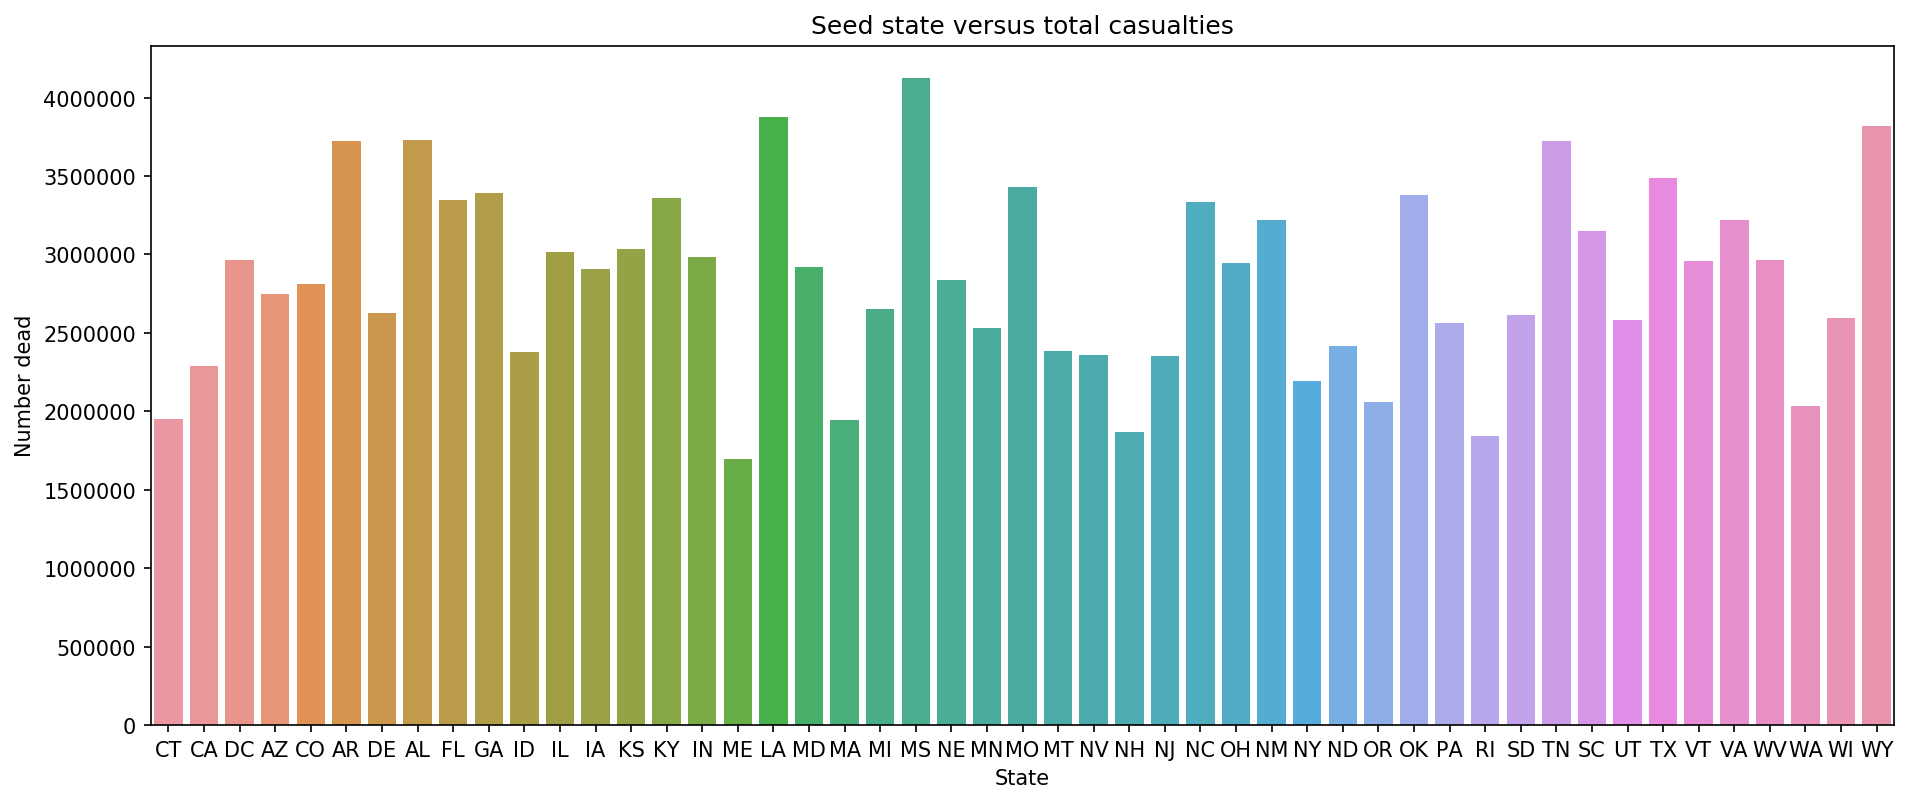

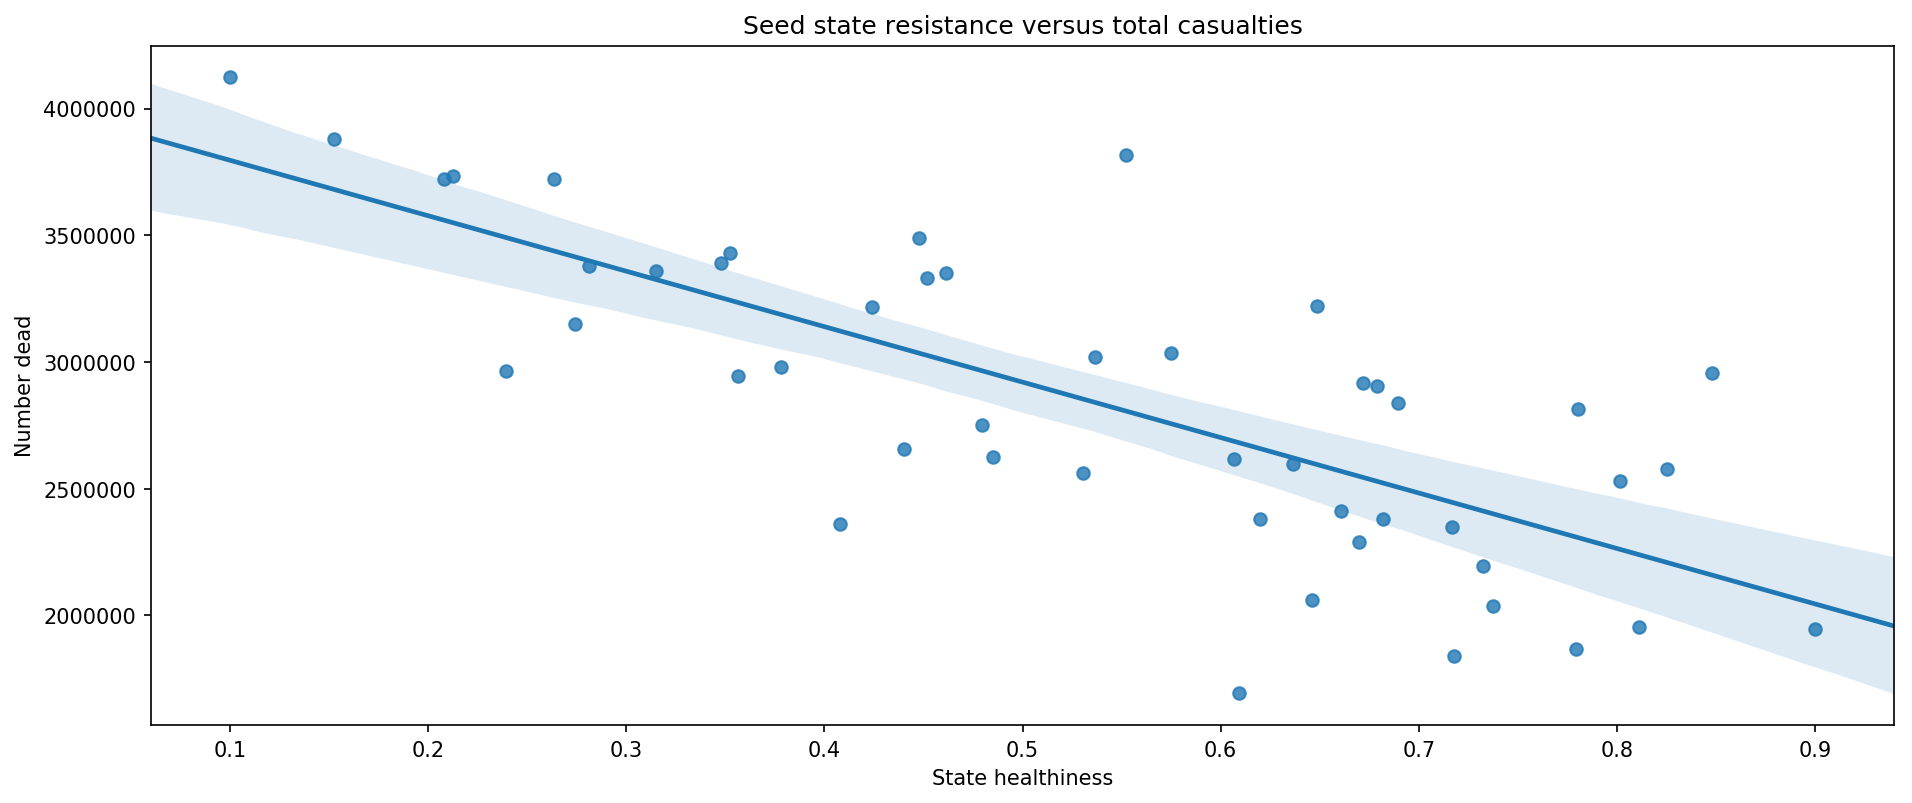

In [33]:
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

#data = pd.read_csv("././data/state-healthiness.csv")
#data = data.sort_values("VALUE")
#data = pd.DataFrame(states.items())
fig = plt.figure(dpi = 150, figsize = (15, 6))
sb.barplot(
    list(states.keys()),
    [abs(states[i]) for i in list(states.keys())]
)
plt.title("Seed state versus total casualties")
plt.xlabel("State")
plt.ylabel("Number dead")

fig = plt.figure(dpi = 150, figsize = (15, 6))
X = [USA_SIM.G.nodes[i]['resistance'] for i in list(states.keys()) if 'resistance' in list(USA_SIM.G.nodes[i].keys())]
Y = [abs(states[i]) for i in list(states.keys()) if 'resistance' in list(USA_SIM.G.nodes[i].keys())]
sb.regplot(X,Y)
slope, intercept, r_value, p_value, std_err = linregress(X,Y)
print("Slope:",slope)
print("Intercept:",intercept)
print("R^2:",r_value**2)
print("P^2:",p_value**2)
print("Standard deviation:",std_err)
print("Average # deaths:", sum(Y)/len(Y))

plt.title("Seed state resistance versus total casualties")
plt.xlabel("State healthiness")
plt.ylabel("Number dead")
print("")

### Results
- For each of the fifty states, we ran 64 trials and averaged the results.
- An infection started in Mississippi would be most likely to cause the largest number of fatalities compared to other states, with an average of 4,125,233 deaths, 1,284,342 more than the average of 2,840,891. Close behind are Louisiana and Wyoming, with 3,878,090 and 3,816,700 respectively.

### Interpretation
- We found that the "severity" of the resulting pandemic — i.e. the number of deaths resulting in the USA once the infection has run its course — is proportional to a number of factors, mainly consisting of the traffic out of the state, the number of bordering states, and the state's overall healthiness metric
- There is a correlation between the state healthiness metric and the resulting number of deaths from an infection starting in that state, $R^2=.56$
- Overall, it seems that the primary influence of an epidemic's severity is the healthiness of its state of origin, not the state's traffic or flight characteristics
- The influence of geography cannot be discounted, though, with an epidemic forming in Maine being essentially localized to the (relatively) remote state